# Capstone: Model Development

<h2 style="color:Blue">Libraries</h2>

In [1]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as PipelineImb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import plotly.express as px
import warnings
from scipy.special import exp10
from scipy import stats
from sklearn.metrics import r2_score
from category_encoders import TargetEncoder
from IPython.display import Markdown as md
from joblib import dump
from joblib import load
import time
import pickle

In [2]:
warnings.filterwarnings('ignore')

<h2 style="color:Blue">Load Data</h2>

In [3]:
churn = pd.read_csv('data/FullChurn.csv')

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4394 entries, 0 to 4393
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        4394 non-null   int64  
 1   IsVIP                     4394 non-null   int64  
 2   CountryCode               4391 non-null   object 
 3   TotalUnits                4394 non-null   int64  
 4   TotalFee                  4394 non-null   float64
 5   Industry                  3414 non-null   object 
 6   Tenure                    4394 non-null   int64  
 7   UsersCount                4394 non-null   int64  
 8   Churn                     4394 non-null   int64  
 9   ChurnPerc                 4394 non-null   float64
 10  TicketsCount              4394 non-null   int64  
 11  TicketsPriorityMean       4394 non-null   float64
 12  TicketsClosedCount        4394 non-null   int64  
 13  SLATimeUsedTotal          4394 non-null   int64  
 14  SLATimeU

In [5]:
churn.head()

ID  IsVIP CountryCode  TotalUnits  TotalFee  \
0  356      0          US          99   2622.58   
1  445      0          US          12    285.98   
2  727      0          US          28    325.00   
3  947      0          US          10    382.98   
4  968      0          US          34    899.70   

                                 Industry  Tenure  UsersCount  Churn  \
0                                     NaN     214           1      1   
1                                     NaN     213           2      1   
2                                     NaN     208           4      0   
3  Utilities: Gas and Electric Industries     206           1      1   
4                                     NaN     206           4      0   

   ChurnPerc  ...  FatigueMonitorCount  FuelSensorCount  PowerOnEventsCount  \
0     100.00  ...                    0                0               40433   
1     100.00  ...                    0                0                  10   
2      73.97  ...                    0                0                 251   
3     100.00  ...                    0                0                9584   
4      32.16  ...                    0                0                3902   

   PricingCancelCount  ClosedBussCancelCount  NoPaymentCancelCount  \
0                   0                      0                     0   
1                   0                      0                     0   
2                   0                      0                     0   
3                   0                      1                     0   
4                   0                      0                     0   

   SoldVehicleCancelCount  NoUsedVehicleCancelCount  MultHWCasesCancelCount  \
0                       1                         3                       0   
1                       0                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   NoUsedCancelCount  
0                  4  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 31 columns]

<h3 style="color:Green">Features</h3>

```
ID: Unique identification code of the company.
IsVIP: Indicates if the customer is a VIP.
CountryCode: Customer's Country Code
TotalUnits: Number of GPS units purchased by the customer.
TotalFee: Total charge for the service provided in USD dollars.
Industry: Industry to which the customer belongs
Tenure: customer's tenure in months
UsersCount: count of users that the customer has on the platform
Churn: Target variable, 1: Churn, 0: Not Churn
ChurnPerc: Percentage of units in Churn
TicketsCount: Count of support cases to date
TicketsPriorityMean: Average priority of support cases(1: low, 2: normal, 3: high)
TicketsClosedCount: count of closed support cases
SLATimeUsedTotal: Total SLA Time Used which is the result of the sum of the SLA time of each case (each case has a maximum time of attention)
SLATimeUsedMean: Average SLA time for all customer's cases
SLAPercentageTotal: Total percentage which is a result of the sum of the SLA percentage spent on each case (a case that exceeds 100% of SLA is that it exceeded the maximum total time previously set for that case)
SLAPercentageMean: Average percentage of SLA use
NonCompliantSLACount: Count of cases that did not comply with the SLA
RMACount: Count of cases returned to manufacturer for each customer in case of warranty
RMAUnitsCount: Count of units returned to the manufacturer for each customer
MDVRCount: Count of MDVR cameras owned by customer
FatigueMonitorCount: Count of fatigue/drowsiness sensors owned by customer 
FuelSensorCount: Count of fuel sensors owned by the customer 
PowerOnEventsCount: Count of power on/off events of the GPS units owned by the customer
PricingCancelCount: Count of requests for cancellation of customer's units for reasons of too high price of the service.
ClosedBussCancelCount: Count of cancellation requests from the customer for reasons of business closure or bankruptcy.
NoPaymentCancelCount: Count of customer's unit cancellation requests due to non-payment of invoices.
SoldVehicleCancelCount: Count of requests for cancellation of customer's units due to sale of vehicles
NoUsedVehicleCancelCount: Count of customer's unit cancellation requests due to unused vehicles
MultHWCasesCancelCount: Count of customer's unit cancellation requests due to hardware problems in units
NoUsedCancelCount: Count of customer's unit cancellation requests due to units not being used by customer
```

<h2 style="color:Blue">Cleaning</h2>

<h3 style="color:Green">Null Analysis</h3>

Data analysis and nulls

In [6]:
churn_null = churn.isnull().sum().sort_values().reset_index()
churn_null.columns = ['Feature', 'Count']
churn_null['%'] = round(churn_null['Count'] / len(churn)* 100, 2 )
churn_null

Feature  Count      %
0                         ID      0   0.00
1   NoUsedVehicleCancelCount      0   0.00
2     SoldVehicleCancelCount      0   0.00
3       NoPaymentCancelCount      0   0.00
4      ClosedBussCancelCount      0   0.00
5         PricingCancelCount      0   0.00
6         PowerOnEventsCount      0   0.00
7            FuelSensorCount      0   0.00
8        FatigueMonitorCount      0   0.00
9                  MDVRCount      0   0.00
10             RMAUnitsCount      0   0.00
11                  RMACount      0   0.00
12      NonCompliantSLACount      0   0.00
13         SLAPercentageMean      0   0.00
14    MultHWCasesCancelCount      0   0.00
15        SLAPercentageTotal      0   0.00
16          SLATimeUsedTotal      0   0.00
17        TicketsClosedCount      0   0.00
18       TicketsPriorityMean      0   0.00
19              TicketsCount      0   0.00
20                 ChurnPerc      0   0.00
21                     Churn      0   0.00
22                UsersCount      0   0.00
23                    Tenure      0   0.00
24                  TotalFee      0   0.00
25                TotalUnits      0   0.00
26                     IsVIP      0   0.00
27           SLATimeUsedMean      0   0.00
28         NoUsedCancelCount      0   0.00
29               CountryCode      3   0.07
30                  Industry    980  22.30

Text(0, 0.5, '% Null')

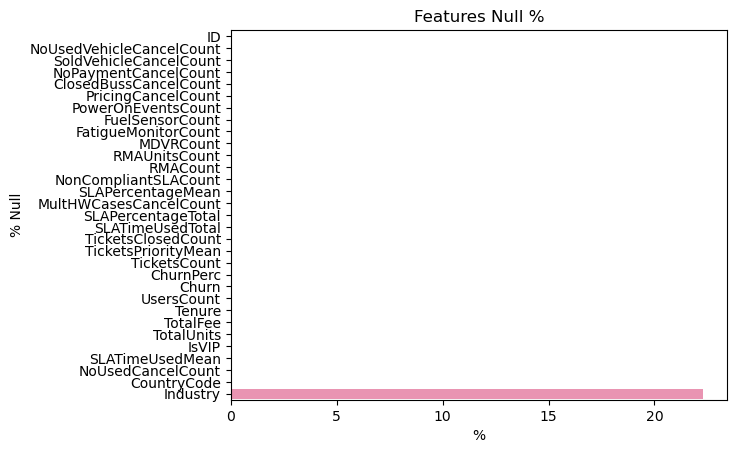

In [7]:
sns.barplot(data = churn_null, y = 'Feature', x = '%')
plt.title('Features Null %')
plt.xticks(rotation=0)
plt.ylabel('% Null')

In [8]:
cats = ['Industry', 'CountryCode']
for cat in cats:
    temp_cat_df = churn[cat].value_counts().reset_index().sort_values(by = 'count', ascending = False)
    display(temp_cat_df)

Industry  count
0                                  Transportation   1314
1                      Transportation & Logistics    658
2                                         Service    394
3                                          Rental    214
4                                      Accounting    166
..                                            ...    ...
61                Property & Real Estate Services      1
60  Oil and Gas Equipment and Services Industries      1
58                          Apparel & Accessories      1
57                     Marketing & Communications      1
67             Toys and Sporting Goods Industries      1

[68 rows x 2 columns]

CountryCode  count
0           CO   2194
1           US   1345
2           PE    679
3           MX    130
4           CA     24
5           PM      6
6           GB      5
7           AU      4
8           CJ      2
9           BF      1
10          Co      1

<h3 style="color:Green">Final Cleaning</h3>

Data cleaning

In [9]:
churn_clean = churn.copy()

churn_clean = churn_clean.drop(['ID', 'ChurnPerc'], axis = 1)

churn_clean['CountryCode'] = churn_clean['CountryCode'].fillna(churn_clean["CountryCode"].mode()[0])
churn_clean['Industry'] = churn_clean['Industry'].fillna(churn_clean["Industry"].mode()[0])
churn_clean

IsVIP CountryCode  TotalUnits  TotalFee  \
0         0          US          99   2622.58   
1         0          US          12    285.98   
2         0          US          28    325.00   
3         0          US          10    382.98   
4         0          US          34    899.70   
...     ...         ...         ...       ...   
4389      0          CO           1    149.75   
4390      0          PE           1     19.99   
4391      0          CO           1    149.75   
4392      0          CO           1    149.75   
4393      0          CO           3    449.25   

                                    Industry  Tenure  UsersCount  Churn  \
0                             Transportation     214           1      1   
1                             Transportation     213           2      1   
2                             Transportation     208           4      0   
3     Utilities: Gas and Electric Industries     206           1      1   
4                             Transportation     206           4      0   
...                                      ...     ...         ...    ...   
4389                                 Service       0           1      0   
4390                          Transportation       0           1      0   
4391                                 Service       0           1      0   
4392                                 Service       0           1      0   
4393                                 Service       0           1      0   

      TicketsCount  TicketsPriorityMean  ...  FatigueMonitorCount  \
0               48                  2.0  ...                    0   
1               13                  2.0  ...                    0   
2               17                  2.0  ...                    0   
3                8                  2.0  ...                    0   
4               12                  2.0  ...                    0   
...            ...                  ...  ...                  ...   
4389             0                  2.0  ...                    0   
4390             0                  2.0  ...                    0   
4391             0                  2.0  ...                    0   
4392             0                  2.0  ...                    0   
4393             0                  2.0  ...                    0   

      FuelSensorCount  PowerOnEventsCount  PricingCancelCount  \
0                   0               40433                   0   
1                   0                  10                   0   
2                   0                 251                   0   
3                   0                9584                   0   
4                   0                3902                   0   
...               ...                 ...                 ...   
4389                0                  28                   0   
4390                0                 154                   0   
4391                0                  47                   0   
4392                0                  21                   0   
4393                0                 299                   0   

      ClosedBussCancelCount  NoPaymentCancelCount  SoldVehicleCancelCount  \
0                         0                     0                       1   
1                         0                     0                       0   
2                         0                     0                       0   
3                         1                     0                       0   
4                         0                     0                       0   
...                     ...                   ...                     ...   
4389                      0                     0                       0   
4390                      0                     0                       0   
4391                      0                     0                       0   
4392                      0                     0                       0   
4393                      0                     0          

<h3 style="color:Green">Duplicates</h3>

Duplicate analysis

In [10]:
duplicate_count = churn_clean.duplicated().value_counts()
duplicates_per = round(duplicate_count[0] / len(churn_clean) * 100, 2)
no_duplicates_per = round(duplicate_count[1] / len(churn_clean) * 100, 2)
print(f"No Duplicates: {duplicate_count[0]} ({duplicates_per}%)")
print(f"Duplicates: {duplicate_count[1]} ({no_duplicates_per}%)")

No Duplicates: 4311 (98.11%)
Duplicates: 83 (1.89%)


In [11]:
#churn_clean = churn_clean.drop_duplicates()

<h2 style="color:Blue">Balance And Correlations</h2>

<h3 style="color:Green">Balance</h3>

Churn  proportion
0      0    0.553254
1      1    0.446746

Text(0, 0.5, 'Proportion')

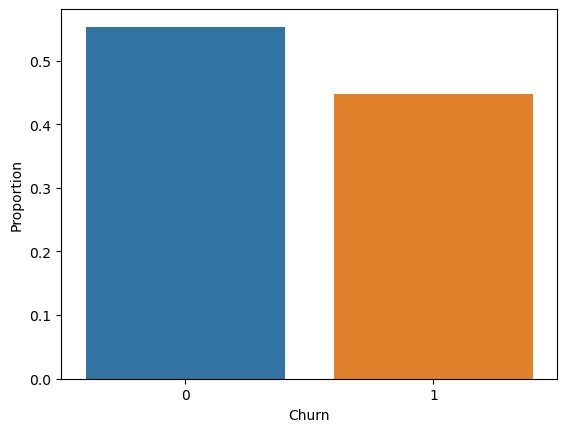

In [12]:
values_ct = churn_clean['Churn'].value_counts(normalize = True)
values_ct = values_ct.reset_index()
display(values_ct)
sns.barplot(values_ct, x = 'Churn', y = 'proportion')
plt.ylabel('Proportion')

The data is slightly unbalanced according to the above graph.

<h3 style="color:Green">Correlations</h3>

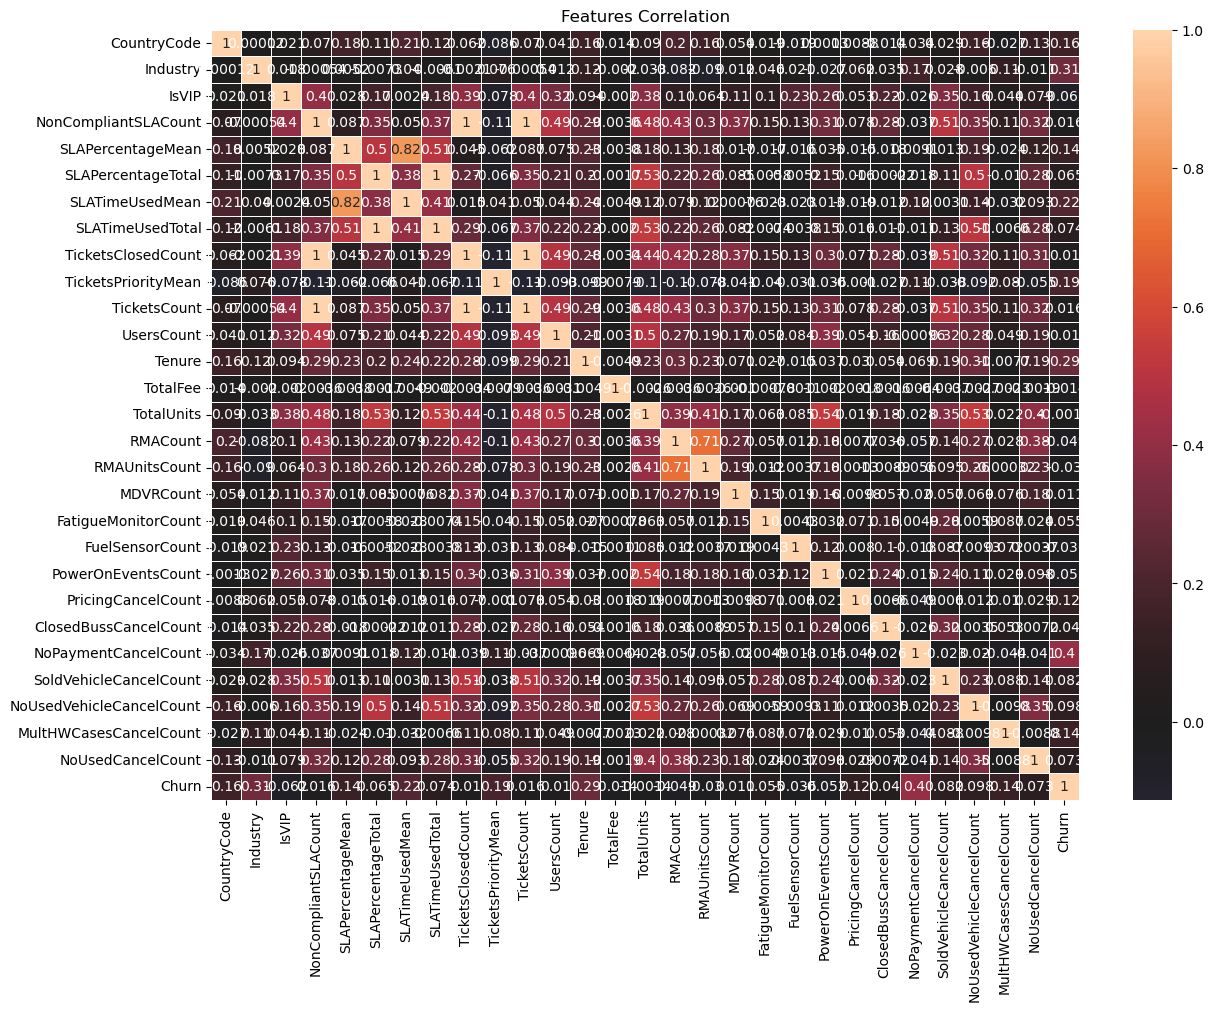

In [13]:
cats = ['CountryCode' , 'Industry']
trg_enc = TargetEncoder()
churn_corr = pd.concat([trg_enc.fit_transform(churn_clean[cats] , churn_clean["Churn"]), 
                          churn_clean[['IsVIP', 'NonCompliantSLACount', 'SLAPercentageMean', 'SLAPercentageTotal', 'SLATimeUsedMean', 'SLATimeUsedTotal', 'TicketsClosedCount', \
                                          'TicketsPriorityMean', 'TicketsCount', 'UsersCount', 'Tenure', 'TotalFee','TotalUnits', 'RMACount', 'RMAUnitsCount',
                                       'MDVRCount','FatigueMonitorCount','FuelSensorCount','PowerOnEventsCount','PricingCancelCount','ClosedBussCancelCount','NoPaymentCancelCount',
                                       'SoldVehicleCancelCount','NoUsedVehicleCancelCount', 'MultHWCasesCancelCount','NoUsedCancelCount','Churn']]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');

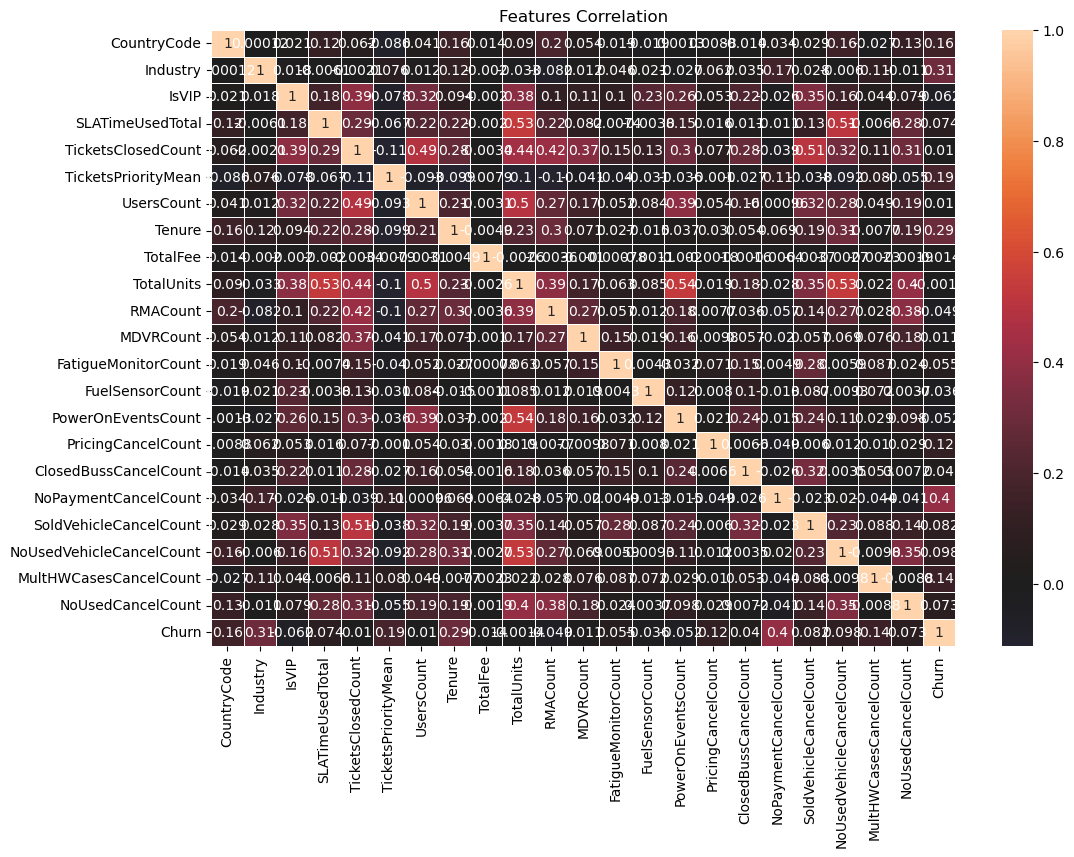

In [14]:
cats = ['CountryCode' , 'Industry']
trg_enc = TargetEncoder()
churn_corr = pd.concat([trg_enc.fit_transform(churn_clean[cats] , churn_clean["Churn"]), 
                          churn_clean[['IsVIP', 'SLATimeUsedTotal', 'TicketsClosedCount', \
                                          'TicketsPriorityMean', 'UsersCount', 'Tenure', 'TotalFee','TotalUnits', 'RMACount', 
                                       'MDVRCount','FatigueMonitorCount','FuelSensorCount','PowerOnEventsCount','PricingCancelCount','ClosedBussCancelCount','NoPaymentCancelCount',
                                        'SoldVehicleCancelCount','NoUsedVehicleCancelCount','MultHWCasesCancelCount','NoUsedCancelCount','Churn']]], axis = 1).corr()

sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(churn_corr, center = 0, linewidth = .5, annot = True).set(title='Features Correlation');

Some features with a correlation = 1 are removed.

<h2 style="color:Blue">Variables and Methods</h2>

Creation of some general variables and ploting methods

In [15]:
accuracy_train_list = []
accuracy_test_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
method = []
best_params_list = []
random_state = 40
oversampling = ADASYN()
columns_len = 0
model_list = []
best_estimator_final = None

In [16]:
#Confusion matrix plot
def getConfusionMatrix(y_test, y_test_pred, display_labels):
    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=display_labels)
    disp.plot()
    plt.show()

In [17]:
#Gets the scores for each model
def getScores(y_test, y_test_pred, plotbar = True):
    ps = precision_score(y_test, y_test_pred)
    rc = recall_score(y_test, y_test_pred)
    acc = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [ps, rc, acc, f1]})
    display(scores)
    if plotbar:
        sns.barplot(scores, x = 'Scores', y = 'Values')
    return (ps, rc, acc, f1)

In [18]:
#Draw the Lift plot
def plot_lift_curve(y_val, y_pred, step=0.01):
    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)
    
    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []
    
    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number 
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)
           
   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    axis.grid()
    plt.title('Lift Curve')
    plt.show()

In [19]:
#Draw the AUC and Recall-Precision plot
def getCurves(X_test, estimator):
    test_predictions = estimator.predict_proba(X_test)
    y_lb_test = np.where(y_test == 1, 'Churn', 'Not Churn')
    ig, ax = plt.subplots(1, 2)
    #fig.set_size_inches(12, 12)
    
    fpr, tpr, thresh_rocs = roc_curve(y_lb_test, test_predictions[:, 1], pos_label='Churn')
    roc_auc_value = skcauc(fpr, tpr)
    roc_plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    roc_plt.plot(ax=ax[0])
    ax[0].grid()
    precision, recall, boundaries = precision_recall_curve(y_lb_test, test_predictions[:, 1], pos_label='Churn')
    pre_rec_plot = PrecisionRecallDisplay(precision=precision, recall=recall)
    pre_rec_plot.plot(ax=ax[1])
    ax[1].grid()    

    plot_lift_curve(y_test, y_test_pred)

In [20]:
def createBarCategoryPlot(data, title, x_name, y_name, x_label, y_label, rotation = 45):
    plot_data = data.groupby(x_name)[y_name].value_counts().reset_index()
    plot_data = plot_data.sort_values(by=x_name, ascending=False)
    plot_data[y_name] = np.where(plot_data[y_name] == 1 , 'Yes', 'No')
    
    fig = px.bar(plot_data, x=x_name, y='count',
                color=y_name)
    
    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        title=title
    )
    fig.show()

<h2 style="color:Blue">Split Data</h2>

In [21]:
X = churn_clean.drop(['Churn', 'SLAPercentageMean', 'TicketsClosedCount', 'SLAPercentageTotal', 'SLATimeUsedMean', 'RMAUnitsCount', 'NonCompliantSLACount'], axis = 1)
y = churn_clean['Churn']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
columns_len = len(X_train.columns)
X_train

IsVIP CountryCode  TotalUnits  TotalFee              Industry  Tenure  \
2942      0          CO           1     29.99        Transportation      26   
1492      0          US           2    199.96        Transportation      70   
1216      0          US           6    143.70            Technology      85   
1052      0          MX           5    149.95        Transportation      95   
3756      0          US           1     19.99        Transportation       9   
...     ...         ...         ...       ...                   ...     ...   
2103      0          CO          11    199.90            Accounting      48   
3603      0          CO           1     29.99        Transportation      11   
3340      0          PE           1     19.99        Transportation      17   
3064      0          CO           1     19.99        Transportation      23   
3398      0          CO          17    509.83  Construction General      15   

      UsersCount  TicketsCount  TicketsPriorityMean  SLATimeUsedTotal  ...  \
2942           1             4                  3.0                 0  ...   
1492           6             2                  2.0               971  ...   
1216           1             1                  3.0            482900  ...   
1052           2             0                  2.0                 0  ...   
3756           1             0                  2.0                 0  ...   
...          ...           ...                  ...               ...  ...   
2103           2            10                  2.0            154646  ...   
3603           1             1                  3.0                 0  ...   
3340           1             3                  3.0                 0  ...   
3064           1             0                  2.0                 0  ...   
3398           1            12                  2.0            172077  ...   

      FatigueMonitorCount  FuelSensorCount  PowerOnEventsCount  \
2942                    0                0               15529   
1492                    0                0                3118   
1216                    0                0                 781   
1052                    0                0                 508   
3756                    0                0                 200   
...                   ...              ...                 ...   
2103                    0                0                6864   
3603                    0                0                  53   
3340                    0                0                1758   
3064                    0                0                1701   
3398                    0               15                7237   

      PricingCancelCount  ClosedBussCancelCount  NoPaymentCancelCount  \
2942                   0                      0                     0   
1492                   0                      0                     0   
1216                   0                      0                     1   
1052                   0                      0                     0   
3756                   0                      0                     0   
...                  ...                    ...                   ...   
2103                   0                      1                     0   
3603                   0                      0                     0   
3340                   0                      0                     0   
3064                   0                      0                     0   
3398                   0                      0                     0   

      SoldVehicleCancelCount  NoUsedVehicleCancelCount  \
2942                       0                         0   
1492                       0                         0   
1216                       0                         0   
1052                       0                         0   
3756                       0                         0   
...                      ...                       ...   
2103                       0                

<h2 style="color:Blue">Models</h2>

<h3 style="color:Green">Dummy Model</h3>

<h4 style="color:Gray">Model Definition</h4>

In [23]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

dm_pipe = Pipeline([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('model', DummyClassifier(strategy="uniform"))
    ])

dm_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()),
                ('model', DummyClassifier(strategy='uniform'))])

<h4 style="color:Gray">Model Results</h4>

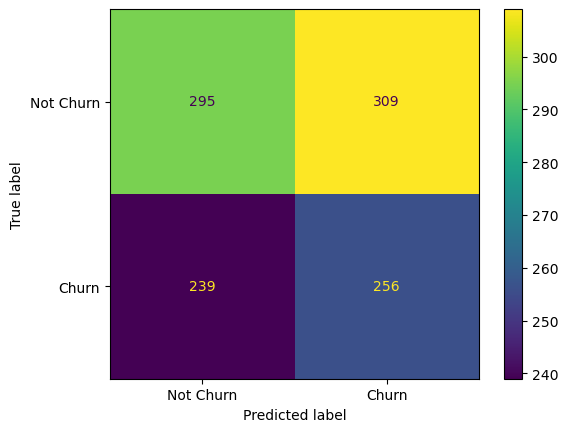

Scores    Values
0  Precision  0.445618
1     Recall  0.488420
2   Accuracy  0.501366
3         F1  0.466038

Scores    Values
0  Precision  0.453097
1     Recall  0.517172
2   Accuracy  0.501365
3         F1  0.483019

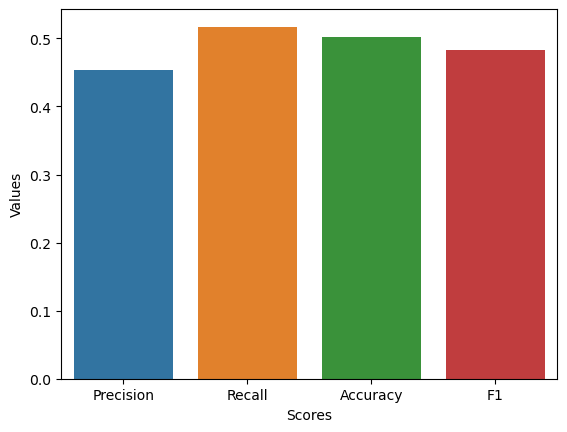

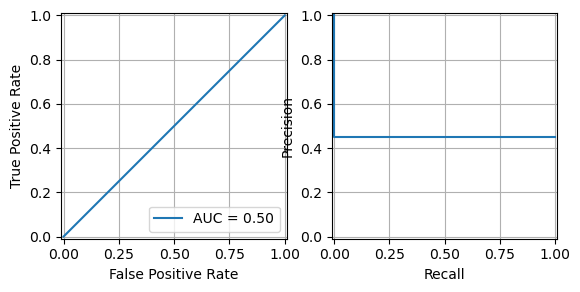

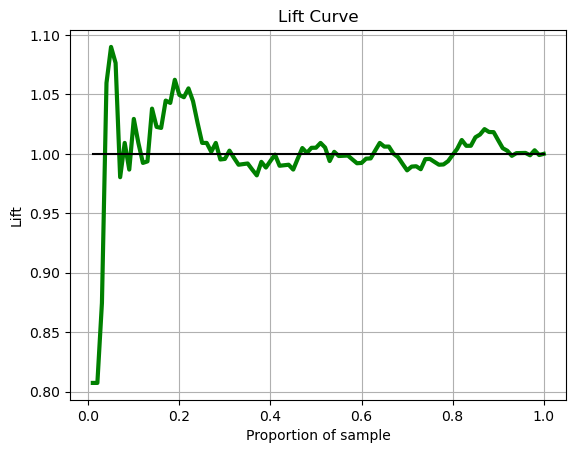

In [24]:
start = time.time()

best_est = dm_pipe
best_est.fit(X_train, y_train)

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('Dummy Classifier')
best_params_list.append({})
model_list.append(best_est)

<h3 style="color:Green">Logistic Regression</h3>

<h4 style="color:Gray">Model Definition</h4>

In [25]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

lr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state=random_state, max_iter = 1000))
    ])

lr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model',
                 LogisticRegression(max_iter=1000, penalty='l1',
                                    random_state=40, solver='liblinear'))])

<h4 style="color:Gray">Model Results</h4>

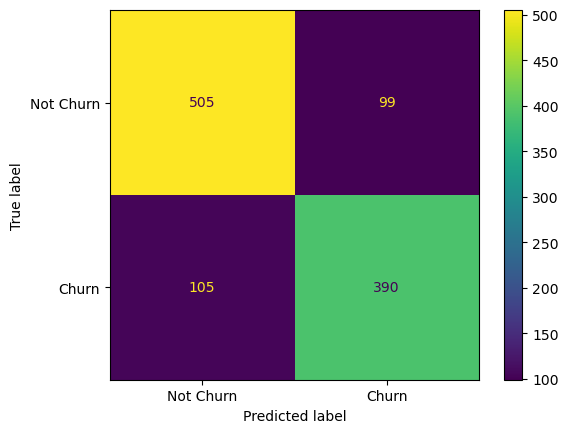

Scores    Values
0  Precision  0.793246
1     Recall  0.784060
2   Accuracy  0.812747
3         F1  0.788626

Scores    Values
0  Precision  0.797546
1     Recall  0.787879
2   Accuracy  0.814377
3         F1  0.792683

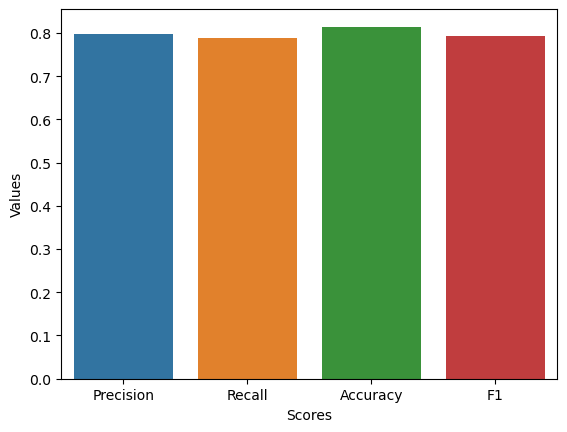

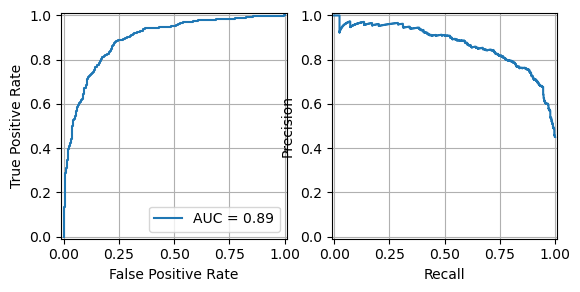

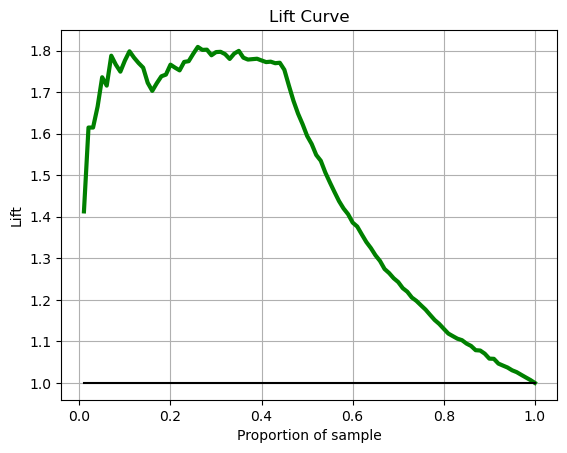

{'model__C': 1.8858632787726515}

In [26]:
start = time.time()

params = {'model__C': np.logspace(-5, .5)}
grid = GridSearchCV(lr_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('Logistic Regression')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">KNN</h3>

<h4 style="color:Gray">Model Definition</h4>

In [27]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

k_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model',KNeighborsClassifier())
    ])

k_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', KNeighborsClassifier())])

<h4 style="color:Gray">Model Results</h4>

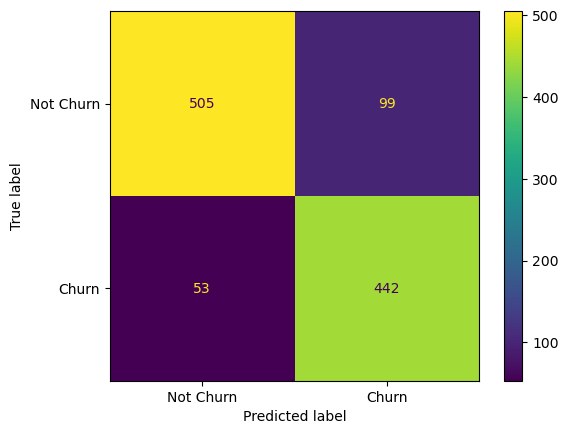

Scores    Values
0  Precision  0.811758
1     Recall  0.931199
2   Accuracy  0.873141
3         F1  0.867386

Scores    Values
0  Precision  0.817006
1     Recall  0.892929
2   Accuracy  0.861692
3         F1  0.853282

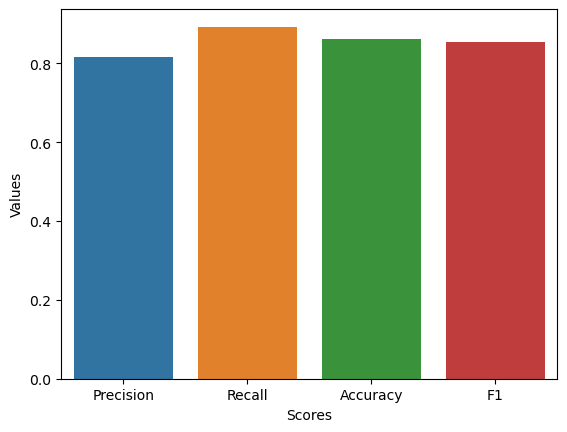

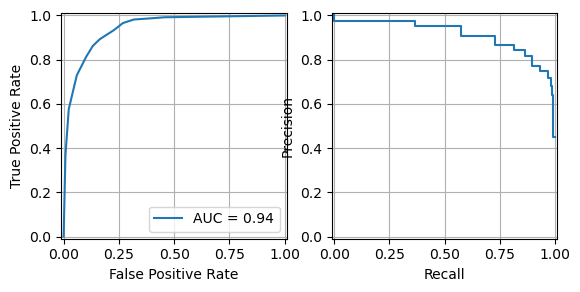

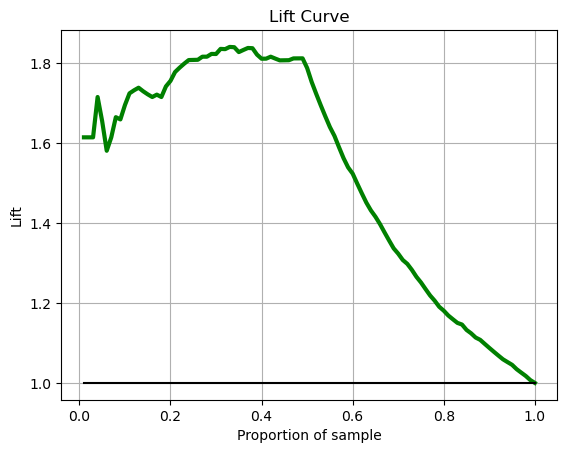

{'model__n_neighbors': 11}

In [28]:
start = time.time()

params = {'model__n_neighbors': range(5, 22, 2)}
grid = GridSearchCV(k_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('KNN')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">Decision Tree</h3>

<h4 style="color:Gray">Model Definition</h4>

In [29]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

t_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', DecisionTreeClassifier(random_state=random_state))
    ])

t_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', DecisionTreeClassifier(random_state=40))])

<h4 style="color:Gray">Model Results</h4>

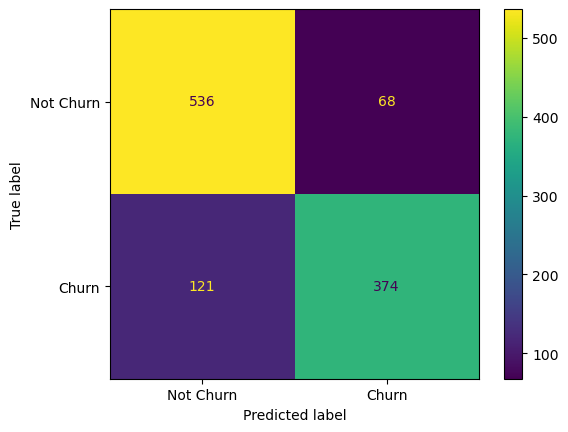

Scores    Values
0  Precision  0.889050
1     Recall  0.835150
2   Accuracy  0.880121
3         F1  0.861257

Scores    Values
0  Precision  0.846154
1     Recall  0.755556
2   Accuracy  0.828025
3         F1  0.798292

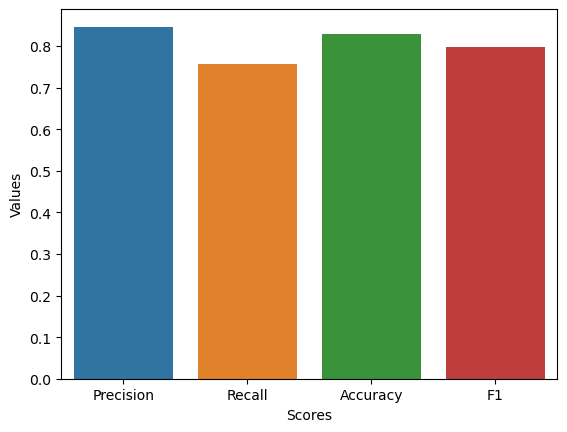

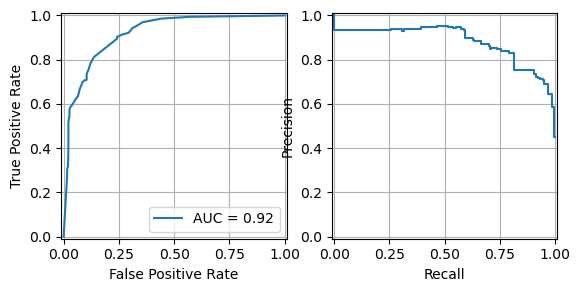

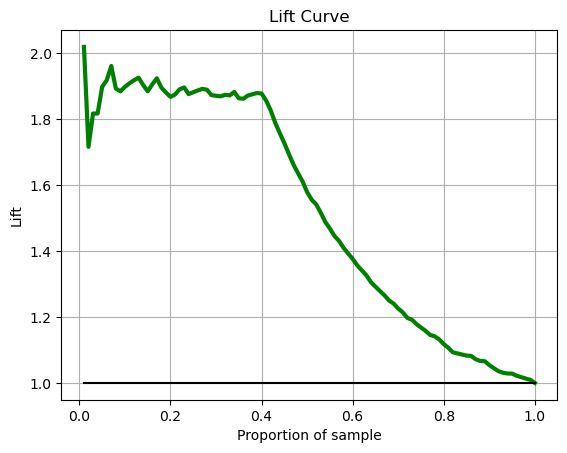

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 2}

In [30]:
start = time.time()

params = {'model__max_depth': [1,2,3,4,5,6,7,8],
         'model__min_samples_split': [2,4,6,8],
          'model__criterion': ['gini', 'entropy'],
          'model__min_samples_leaf': [1,2,4,6]
         }
grid = GridSearchCV(t_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('Decision Tree')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">SVM</h3>

<h4 style="color:Gray">Model Definition</h4>

In [31]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

svr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', SVC(probability=True, coef0=1, gamma='scale', random_state=random_state))
    ])

svr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', SVC(coef0=1, probability=True, random_state=40))])

<h4 style="color:Gray">Model Results</h4>

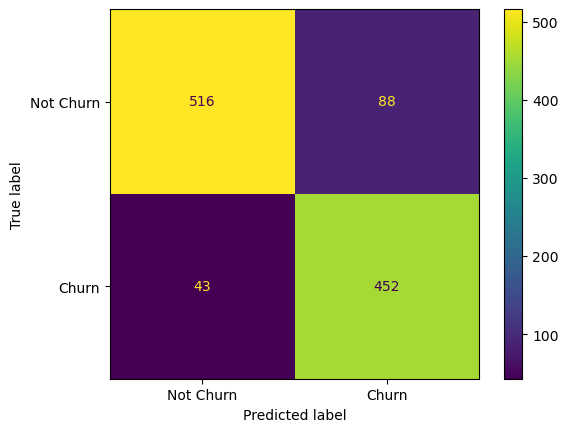

Scores    Values
0  Precision  0.850998
1     Recall  0.929837
2   Accuracy  0.896206
3         F1  0.888672

Scores    Values
0  Precision  0.837037
1     Recall  0.913131
2   Accuracy  0.880801
3         F1  0.873430

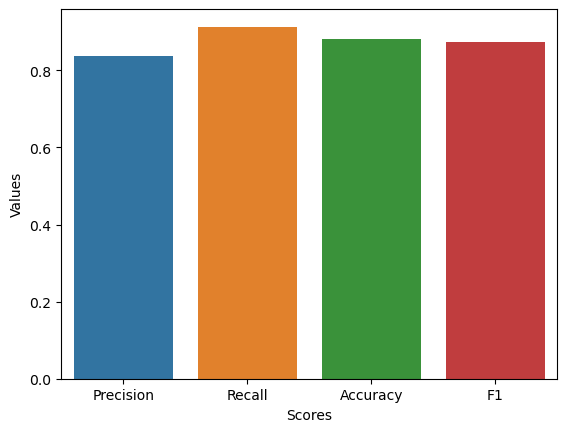

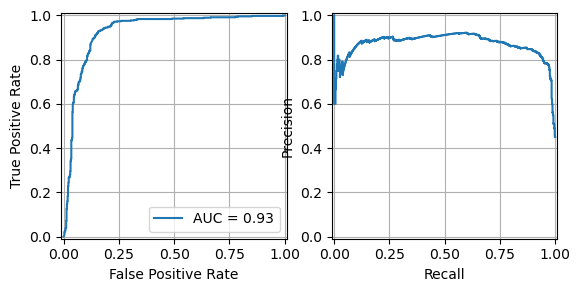

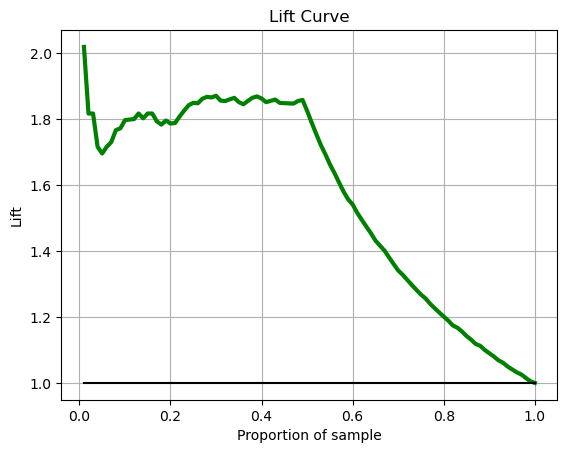

{'model__C': 1, 'model__degree': 3, 'model__kernel': 'poly'}

In [32]:
start = time.time()

params = {'model__C': [0.1, 1, 1,5,10], 'model__kernel': ('poly', 'rbf'),'model__degree' : [2,3,4]}
#grid = HalvingRandomSearchCV(svr_pipe, param_distributions=params, scoring = 'f1').fit(X_train, y_train)
grid = GridSearchCV(svr_pipe, param_grid=params, scoring = 'f1', cv = 3).fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
display(grid.best_params_)
method.append('SVM')
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">SGD</h3>

<h4 style="color:Gray">Model Definition</h4>

In [33]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

sgd_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', SGDClassifier(penalty='l2', max_iter = 1000, random_state=random_state))
    ])

sgd_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model', SGDClassifier(random_state=40))])

<h4 style="color:Gray">Model Results</h4>

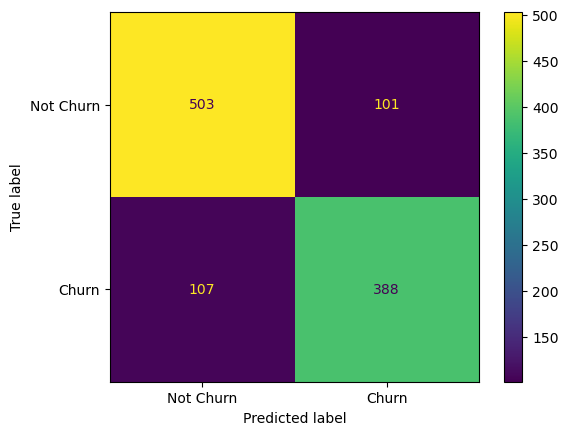

Scores    Values
0  Precision  0.777778
1     Recall  0.782016
2   Accuracy  0.803338
3         F1  0.779891

Scores    Values
0  Precision  0.793456
1     Recall  0.783838
2   Accuracy  0.810737
3         F1  0.788618

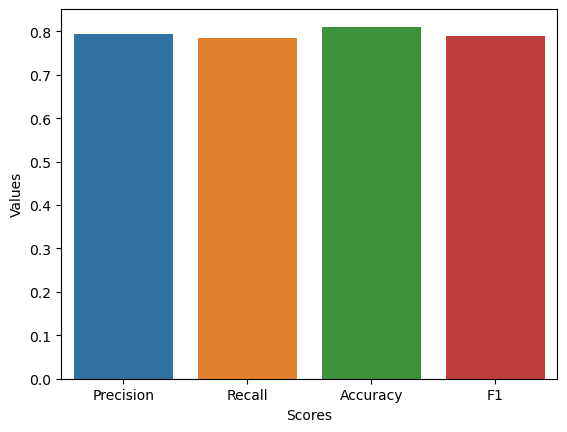

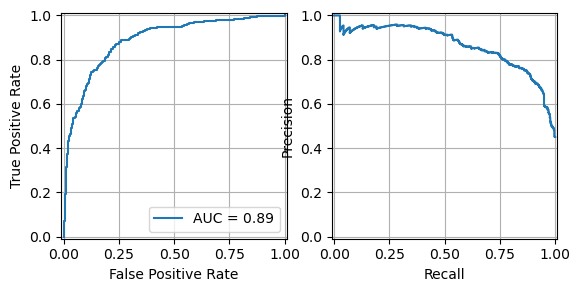

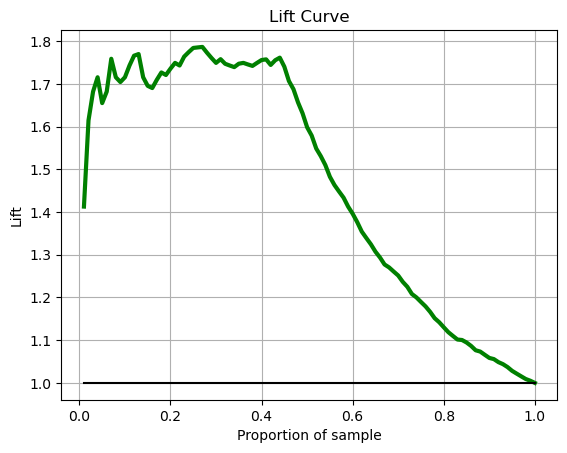

{'model__alpha': 0.001, 'model__loss': 'log_loss'}

In [34]:
start = time.time()

params = {'model__loss': ['log_loss', 'modified_huber'],
         'model__alpha': [0.0001, 0.001]
         }
grid = GridSearchCV(sgd_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('SGD')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">Random Forest Classifier</h3>

<h4 style="color:Gray">Model Definition</h4>

In [35]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

rfr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', RandomForestClassifier(
            random_state=random_state, 
            criterion = best_params_list[3]['model__criterion'],
            max_depth = best_params_list[3]['model__max_depth'],
            min_samples_leaf = best_params_list[3]['model__min_samples_leaf'],
            min_samples_split = best_params_list[3]['model__min_samples_split'],
        ))
    ])

rfr_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=6,
                                        random_state=40))])

<h4 style="color:Gray">Model Results</h4>

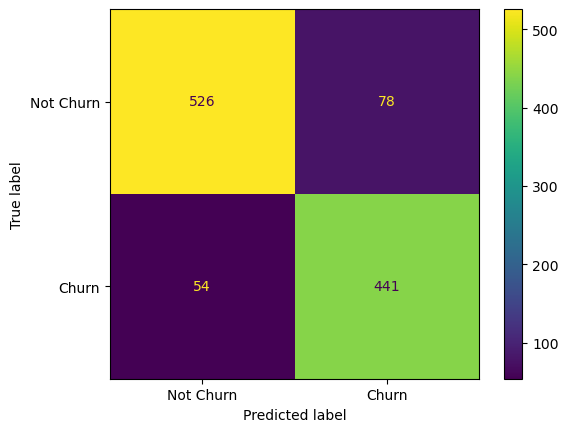

Scores    Values
0  Precision  0.874282
1     Recall  0.933243
2   Accuracy  0.910470
3         F1  0.902801

Scores    Values
0  Precision  0.849711
1     Recall  0.890909
2   Accuracy  0.879891
3         F1  0.869822

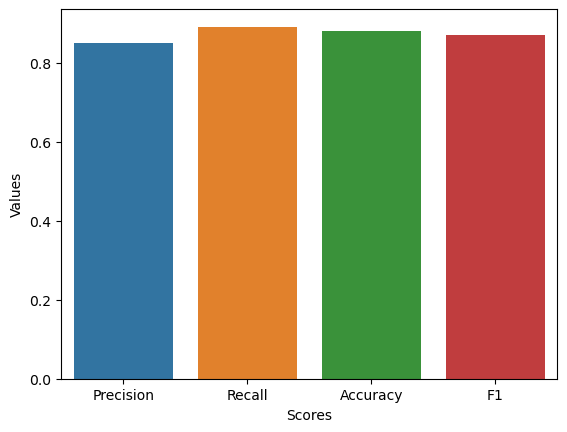

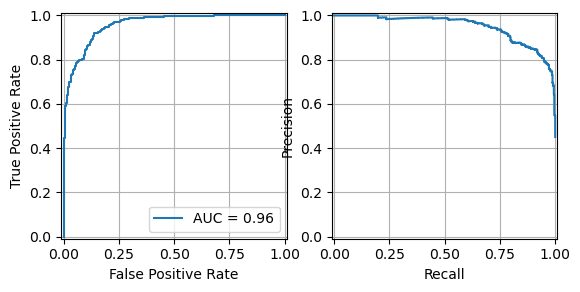

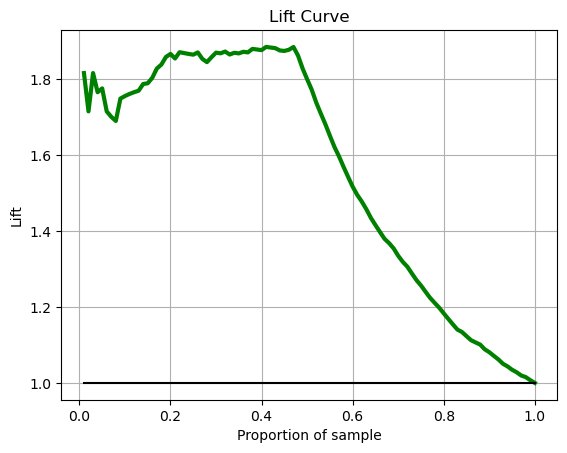

{'model__n_estimators': 300}

In [36]:
start = time.time()

params = {
          'model__n_estimators': [100, 150, 200, 300]
         }
grid = GridSearchCV(rfr_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('Random Forest Classifier')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">AdaBoost Classifier</h3>

<h4 style="color:Gray">Model Definition</h4>

In [37]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

ada_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', AdaBoostClassifier(
            random_state=random_state, 
            estimator = DecisionTreeClassifier(
                criterion = best_params_list[3]['model__criterion'],
                max_depth = best_params_list[3]['model__max_depth'],
                min_samples_leaf = best_params_list[3]['model__min_samples_leaf'],
                min_samples_split = best_params_list[3]['model__min_samples_split']
            )
        ))
    ])

ada_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                                     min_samples_leaf=6),
                                    random_state=40))])

<h4 style="color:Gray">Model Results</h4>

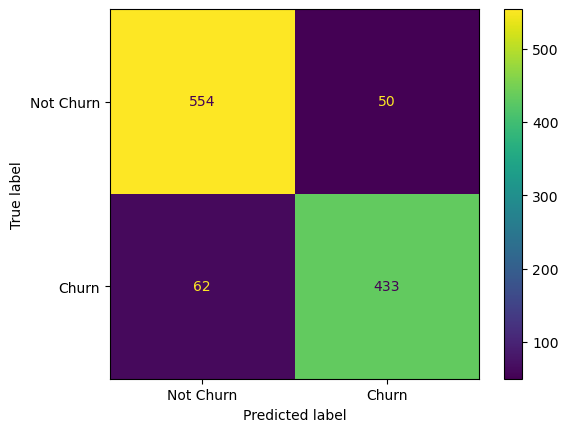

Scores  Values
0  Precision     1.0
1     Recall     1.0
2   Accuracy     1.0
3         F1     1.0

Scores    Values
0  Precision  0.896480
1     Recall  0.874747
2   Accuracy  0.898089
3         F1  0.885481

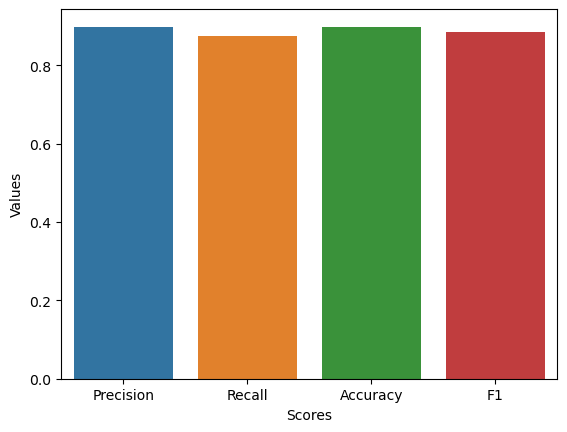

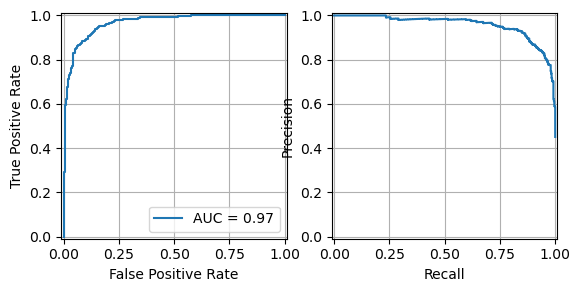

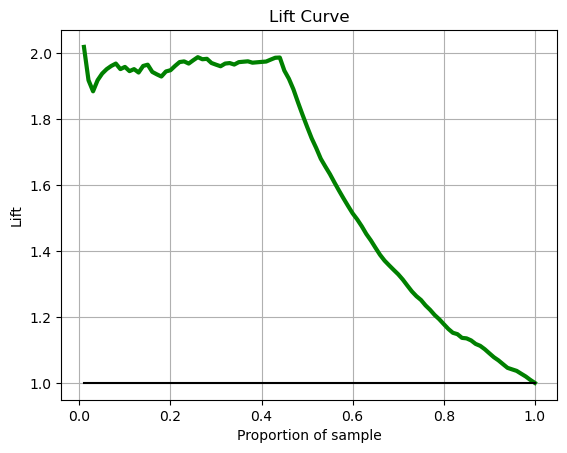

{'model__n_estimators': 300}

In [38]:
start = time.time()

params = {
          'model__n_estimators': [100, 150, 200, 300]
         }
grid = GridSearchCV(ada_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('AdaBoost Classifier')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">Gradient Boosting Classifier</h3>

<h4 style="color:Gray">Model Definition</h4>

In [39]:
cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)

adb_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling),
        ('model', GradientBoostingClassifier(
            random_state=random_state, 
            max_depth = best_params_list[3]['model__max_depth'],
            min_samples_leaf = best_params_list[3]['model__min_samples_leaf'],
            min_samples_split = best_params_list[3]['model__min_samples_split']         
        ))
    ])

adb_pipe

Pipeline(steps=[('tranform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['CountryCode',
                                                   'Industry'])])),
                ('stdscl', StandardScaler()), ('sampling', ADASYN()),
                ('model',
                 GradientBoostingClassifier(max_depth=8, min_samples_leaf=6,
                                            random_state=40))])

<h4 style="color:Gray">Model Results</h4>

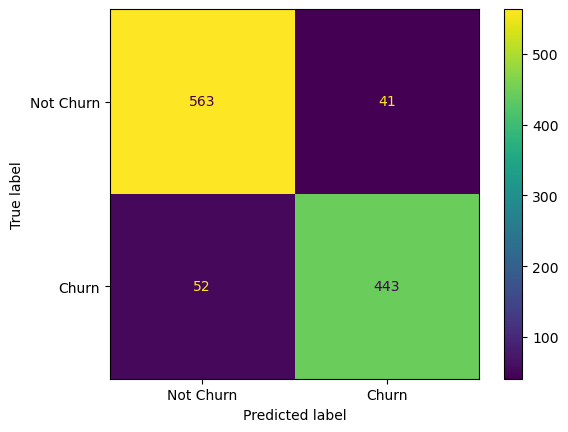

Scores  Values
0  Precision     1.0
1     Recall     1.0
2   Accuracy     1.0
3         F1     1.0

Scores    Values
0  Precision  0.915289
1     Recall  0.894949
2   Accuracy  0.915378
3         F1  0.905005

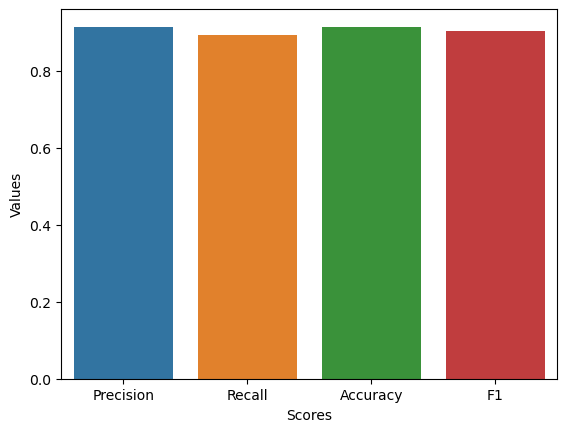

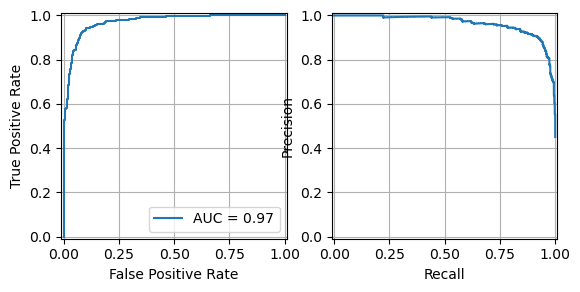

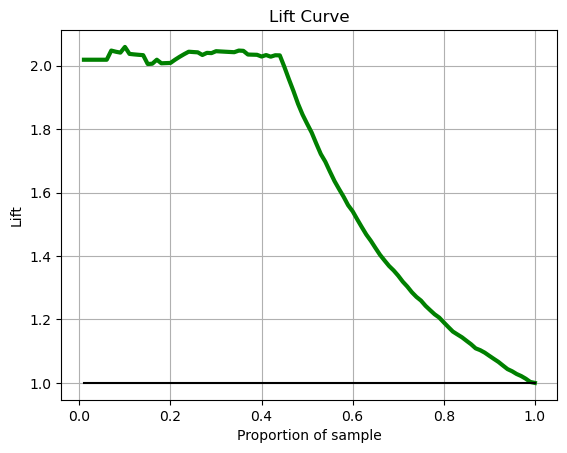

{'model__criterion': 'squared_error',
 'model__learning_rate': 0.1,
 'model__n_estimators': 150}

In [40]:
start = time.time()

params = {
          'model__n_estimators': [100, 150, 200, 300],
          'model__criterion': ['friedman_mse','squared_error'],
          'model__learning_rate': [0.1, 0.5, 1]
         }
grid = GridSearchCV(adb_pipe, param_grid=params, scoring = 'f1').fit(X_train, y_train)
best_est = grid.best_estimator_

end = time.time()
total_time = end - start

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

getConfusionMatrix(y_test, y_test_pred, display_labels=['Not Churn', 'Churn'])

pst, rct, acct, f1t = getScores(y_train, y_train_pred, plotbar = False)
ps, rc, acc, f1 = getScores(y_test, y_test_pred)

getCurves(X_test, best_est)

precision_list.append(ps)
recall_list.append(rc)
accuracy_test_list.append(acc)
accuracy_train_list.append(acct)
f1_list.append(f1)
time_list.append(total_time)
method.append('Gradient Boosting Classifier')
display(grid.best_params_)
best_params_list.append(grid.best_params_)
model_list.append(best_est)

<h3 style="color:Green">Neural Network</h3>

<h4 style="color:Gray">Model Definition</h4>

In [41]:
def model_builder(hp):
    model = Sequential()
    
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=50, step=2)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=50, step=2)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(Dense(units = columns_len, activation = hp_activation))
    model.add(Dense(units = hp_layer_1, activation = hp_activation))
    model.add(Dense(units = hp_layer_2, activation = hp_activation))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = Adam(learning_rate=hp_learning_rate),
                loss='bce',
                metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
  
    return model

In [42]:
tuner = kt.Hyperband(model_builder,
                     objective=[kt.Objective("val_recall", direction="max"),kt.Objective("val_precision", direction="max")],
                     max_epochs=10,
                     factor=3)

cats = ['CountryCode' , 'Industry']
transf = make_column_transformer(
        (TargetEncoder(), cats),
        remainder='passthrough'
)
kr_pipe = PipelineImb([
        ('tranform', transf),
        ('stdscl', StandardScaler()),
        ('sampling', oversampling)
    ])

tx_train, ty_train  = kr_pipe.fit_resample(X_train, y_train)
tx_test, ty_test = kr_pipe.fit_resample(X_test, y_test)

stop_early = EarlyStopping(monitor='val_recall', patience=5)

<h4 style="color:Gray">Model Results</h4>

Trial 30 Complete [00h 00m 02s]
multi_objective: -1.7103956937789917

Best multi_objective So Far: -1.7822139263153076
Total elapsed time: 00h 00m 57s
Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 0.4571 - accuracy: 0.8116 - precision: 0.7900 - recall: 0.8258 - auc: 0.8758 - val_loss: 0.3285 - val_accuracy: 0.8568 - val_precision: 0.8185 - val_recall: 0.9080 - val_auc: 0.9332
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8467 - precision: 0.8155 - recall: 0.8783 - auc: 0.9195 - val_loss: 0.3388 - val_accuracy: 0.8466 - val_precision: 0.8399 - val_recall: 0.8472 - val_auc: 0.9321
Epoch 3/50
110/110 [==============================] - 0s 1ms/step - loss: 0.3327 - accuracy: 0.8507 - precision: 0.8187 - recall: 0.8837 - auc: 0.9299 - val_loss: 0.3176 - val_accuracy: 0.8602 - val_precision: 0.8442 - val_recall: 0.8750 - val_auc: 0.9396
Epoch 4/50
110/110 [==============================] - 0s 1ms/step - loss: 0.3258 

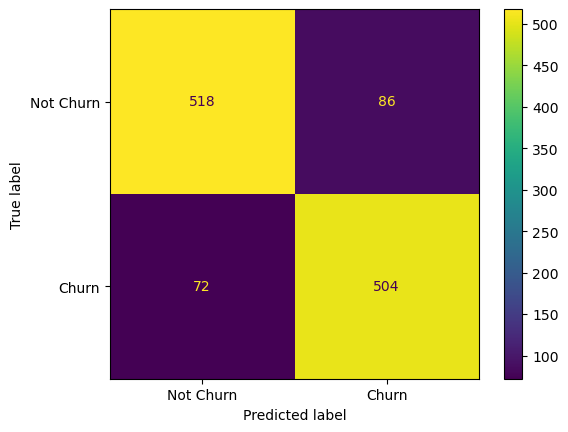

Scores    Values
0  Precision  0.854237
1     Recall  0.875000
2   Accuracy  0.866102
3         F1  0.864494

{'activation': 'relu',
 'layer_1': 45,
 'layer_2': 45,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 22)                506       
                                                                 
 dense_5 (Dense)             (None, 45)                1035      
                                                                 
 dense_6 (Dense)             (None, 45)                2070      
                                                                 
 dense_7 (Dense)             (None, 1)                 46        
                                                                 
Total params: 3,657
Trainable params: 3,657
Non-trainable params: 0
_________________________________________________________________


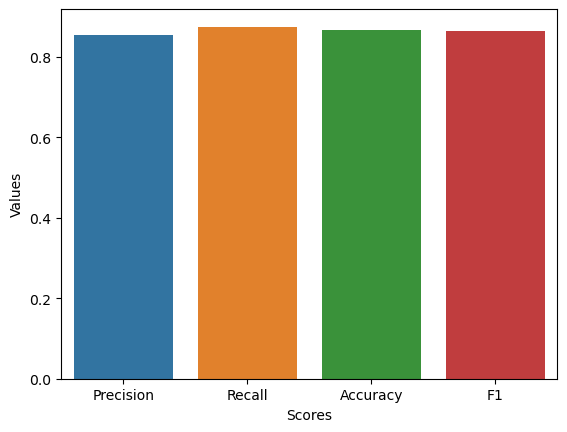

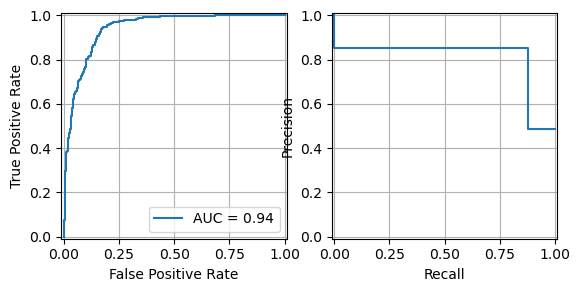

In [43]:
start = time.time()

#Train
tuner.search(tx_train, ty_train, epochs=50, validation_data=(tx_test, ty_test), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(tx_train, ty_train, epochs=50, validation_data=(tx_test, ty_test), callbacks=[stop_early])

end = time.time()
total_time = end - start

accuracy_train = history.history['accuracy'][-1]
accuracy_test = history.history['val_accuracy'][-1]
recall = history.history['val_recall'][-1]
precision = history.history['val_precision'][-1]
f1_score = 2 * (precision * recall) / (precision + recall) 
auc = history.history['val_auc'][-1]

predictions = best_model.predict(tx_test)
ty_pred_test = (predictions > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(ty_test, predictions)

#Confusion Matrix
getConfusionMatrix(ty_test, ty_pred_test, display_labels=['Not Churn', 'Churn'])

#Scores
scores = pd.DataFrame({'Scores':['Precision', 'Recall', 'Accuracy', 'F1'], 'Values' : [precision, recall, accuracy_test, f1_score]})
display(scores)
sns.barplot(scores, x = 'Scores', y = 'Values')

#Curves
roc_plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
ig, ax = plt.subplots(1,2)
roc_plt.plot(ax = ax[0])
ax[0].grid()

y_lb_test = np.where(ty_test == 1, 'Churn', 'Not Churn')

prec, rec, boundaries = precision_recall_curve(y_lb_test, ty_pred_test, pos_label='Churn')
pre_rec_plot = PrecisionRecallDisplay(precision=prec, recall=rec)
pre_rec_plot.plot(ax=ax[1])
ax[1].grid()    

#Summary
display(best_hps.values)
best_model.summary()

precision_list.append(precision)
recall_list.append(recall)
accuracy_test_list.append(accuracy_test)
accuracy_train_list.append(accuracy_train)
f1_list.append(f1_score)
time_list.append(total_time)
best_params_list.append(best_hps.values)
method.append('Neural Network')
model_list.append(best_model)

<h3 style="color:Green">Results</h3>

As can be seen in the score values for each model, SVC has one of the best scores among the others, followed by KNN which is very close behind. SVC performs well and seems to be the most suitable to use for the company's forecasts.

In [44]:
results_t1 = pd.DataFrame({'Method': method, 'Accuracy Train' : accuracy_train_list , 'Accuracy Test': accuracy_test_list, 'Recall': recall_list, 'Precision': precision_list, 'F1' : f1_list, 'Fit Time (Sec)' : time_list, 'Best Params' : best_params_list})
results_t1 = results_t1.sort_values(by=['F1'], ascending=False)
results_t1

Method  Accuracy Train  Accuracy Test    Recall  \
8  Gradient Boosting Classifier        1.000000       0.915378  0.894949   
7           AdaBoost Classifier        1.000000       0.898089  0.874747   
4                           SVM        0.896206       0.880801  0.913131   
6      Random Forest Classifier        0.910470       0.879891  0.890909   
9                Neural Network        0.884099       0.866102  0.875000   
2                           KNN        0.873141       0.861692  0.892929   
3                 Decision Tree        0.880121       0.828025  0.755556   
1           Logistic Regression        0.812747       0.814377  0.787879   
5                           SGD        0.803338       0.810737  0.783838   
0              Dummy Classifier        0.501366       0.501365  0.517172   

   Precision        F1  Fit Time (Sec)  \
8   0.915289  0.905005      179.476049   
7   0.896480  0.885481       36.464341   
4   0.837037  0.873430       45.889515   
6   0.849711  0.869822        8.150823   
9   0.854237  0.864494       59.552931   
2   0.817006  0.853282        2.901590   
3   0.846154  0.798292       51.843824   
1   0.797546  0.792683       10.805217   
5   0.793456  0.788618        0.867282   
0   0.453097  0.483019        0.015513   

                                         Best Params  
8  {'model__criterion': 'squared_error', 'model__...  
7                       {'model__n_estimators': 300}  
4  {'model__C': 1, 'model__degree': 3, 'model__ke...  
6                       {'model__n_estimators': 300}  
9  {'activation': 'relu', 'layer_1': 45, 'layer_2...  
2                         {'model__n_neighbors': 11}  
3  {'model__criterion': 'gini', 'model__max_depth...  
1                   {'model__C': 1.8858632787726515}  
5  {'model__alpha': 0.001, 'model__loss': 'log_lo...  
0                                                 {}

<Axes: xlabel='Method'>

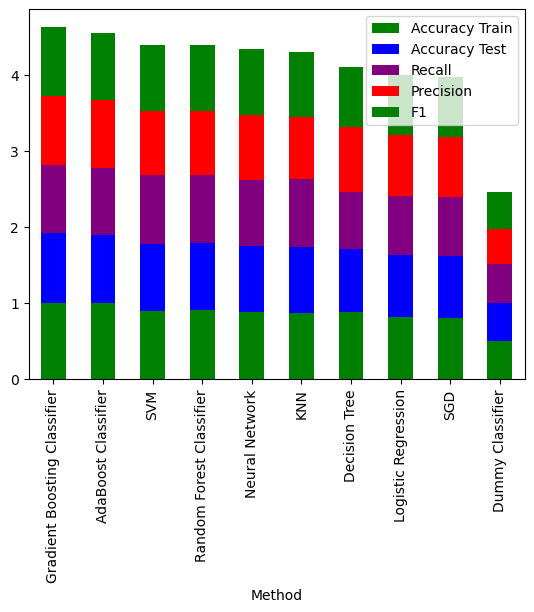

In [45]:
colors = ['green', 'blue', 'purple', 'red']
results_t1.drop('Fit Time (Sec)', axis = 1).set_index('Method').plot(kind='bar', stacked=True, color=colors)

<h2 style="color:Blue">Feature Importance</h2>

In [46]:
best_estimator_final = model_list[results_t1.index[0]]
importances = permutation_importance(best_estimator_final, X_train, y_train, n_repeats = 10, random_state=40)

In [47]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
display(importances_tr)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
display(importances_tr)

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

{'IsVIP': 0.0006980273141122928,
 'CountryCode': 0.024886191198786035,
 'TotalUnits': 0.0872534142640364,
 'TotalFee': 0.054749620637329285,
 'Industry': 0.03435508345978757,
 'Tenure': 0.09890743550834596,
 'UsersCount': 0.004764795144157808,
 'TicketsCount': 0.015902883156297433,
 'TicketsPriorityMean': 0.0023368740515933408,
 'SLATimeUsedTotal': 0.02342943854324735,
 'RMACount': 0.015477996965098639,
 'MDVRCount': 0.0035508345978755517,
 'FatigueMonitorCount': 0.0003945371775417539,
 'FuelSensorCount': 0.0008194233687405128,
 'PowerOnEventsCount': 0.053717754172989365,
 'PricingCancelCount': 0.014658573596358127,
 'ClosedBussCancelCount': 0.01566009104704098,
 'NoPaymentCancelCount': 0.15341426403641883,
 'SoldVehicleCancelCount': 0.12257966616084977,
 'NoUsedVehicleCancelCount': 0.0024582701062215496,
 'MultHWCasesCancelCount': 0.022427921092564473,
 'NoUsedCancelCount': 0.018543247344461312}

{'NoPaymentCancelCount': 0.15341426403641883,
 'SoldVehicleCancelCount': 0.12257966616084977,
 'Tenure': 0.09890743550834596,
 'TotalUnits': 0.0872534142640364,
 'TotalFee': 0.054749620637329285,
 'PowerOnEventsCount': 0.053717754172989365,
 'Industry': 0.03435508345978757,
 'CountryCode': 0.024886191198786035,
 'SLATimeUsedTotal': 0.02342943854324735,
 'MultHWCasesCancelCount': 0.022427921092564473,
 'NoUsedCancelCount': 0.018543247344461312,
 'TicketsCount': 0.015902883156297433,
 'ClosedBussCancelCount': 0.01566009104704098,
 'RMACount': 0.015477996965098639,
 'PricingCancelCount': 0.014658573596358127,
 'UsersCount': 0.004764795144157808,
 'MDVRCount': 0.0035508345978755517,
 'NoUsedVehicleCancelCount': 0.0024582701062215496,
 'TicketsPriorityMean': 0.0023368740515933408,
 'FuelSensorCount': 0.0008194233687405128,
 'IsVIP': 0.0006980273141122928,
 'FatigueMonitorCount': 0.0003945371775417539}

Importances
NoPaymentCancelCount         0.153414
SoldVehicleCancelCount       0.122580
Tenure                       0.098907
TotalUnits                   0.087253
TotalFee                     0.054750
PowerOnEventsCount           0.053718
Industry                     0.034355
CountryCode                  0.024886
SLATimeUsedTotal             0.023429
MultHWCasesCancelCount       0.022428
NoUsedCancelCount            0.018543
TicketsCount                 0.015903
ClosedBussCancelCount        0.015660
RMACount                     0.015478
PricingCancelCount           0.014659
UsersCount                   0.004765
MDVRCount                    0.003551
NoUsedVehicleCancelCount     0.002458
TicketsPriorityMean          0.002337
FuelSensorCount              0.000819
IsVIP                        0.000698
FatigueMonitorCount          0.000395

In [48]:
fig = px.bar(import_df.reset_index(), x="Importances", y = 'index', color='index', labels={'index' : 'Feature'})
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Features Importance"
)
fig.show()

As a main feature we have that the NoPaymentCancelCount feature has a lot of weight when predicting churn followed by tenure, this is probably due to the fact that non-payment of services by customers is a very powerful incentive to terminate a service contract by both parties. The ternure is another case in which the oldest customers are the most likely to leave because they are the most mature when it comes to deciding whether the service offered is really what they need.

MultHWCasesCancelCount is quite interesting as it is a feature that indicates hardware failures and is a very important incentive for a customer to cancel the service. CountryCode is another feature but I think it is quite biased as most of the customers are from LATAM.

<h2 style="color:Blue">Feature Analysis</h2>

<h3 style="color:Green">Churn Count By Industry</h3>

The transportation industry is the company's largest customer followed by miscellaneous services and logistics, it is evident that these sectors are the ones that should be taken into account when predicting churn.

In [49]:
plot_data = churn_clean.groupby('Industry')['Churn'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='count', ascending=False)
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Industry', y='count',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Industry"
)
fig.show()

Industry Churn  count
107                             Transportation    No   1149
108                             Transportation   Yes   1145
109                 Transportation & Logistics   Yes    428
97                                     Service    No    329
110                 Transportation & Logistics    No    230
..                                         ...   ...    ...
87         Pharmaceutical & Medicinal Products   Yes      1
90             Property & Real Estate Services    No      1
45           Environmental Products & Services   Yes      1
71                  Marketing & Communications    No      1
59   Home Equipment and Furnishings Industries    No      1

[118 rows x 3 columns]

<h3 style="color:Green">Churn By Tenure Mean</h3>

The tenure feature is very interesting because as we can see in the graph, the average tenure is higher in customers with churn, that gives us an idea that the customer is more likely to cancel more and more services the longer he has used them. It is necessary to implement a stronger strategy that takes care of the old customers without neglecting the new ones.

In [50]:
plot_data = churn_clean.groupby('Churn')['Tenure'].mean().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='Tenure',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn By Tenure (Mean)"
)
fig.show()

Churn     Tenure
0    No  46.633484
1   Yes  75.753439

<h3 style="color:Green">Churn Mean By No Payment</h3>

The count of service cancellations due to stop paying for the service is notoriously much higher in customers with churn, which is natural, the recommendation is that if a customer stops paying for the service and the reason is because the service does not seem adequate, try to retain him and convert him to continue and pay the value owed.

In [51]:
plot_data = churn_clean.groupby('Churn')['NoPaymentCancelCount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='NoPaymentCancelCount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By No Payment"
)
fig.show()

Churn  NoPaymentCancelCount
0    No                    68
1   Yes                   724

<h3 style="color:Green">Churn Count By Country</h3>

This value indicates that Colombia is the country that has more churn than others, this value is somewhat biased because the USA is no longer a target country for sales but still has loyal customers, the reason is that the USA is under another brand. The real comparison is between Colombia and Peru, and as you can see the churn is very high in Colombia compared to Peru.

In [52]:
plot_data = churn_clean.loc[churn_clean['Churn'] == 1].groupby('CountryCode')['CountryCode'].value_counts().reset_index()
plot_data = plot_data.sort_values(by='count', ascending=False)
display(plot_data)
fig = px.bar(plot_data, x='CountryCode', y='count',
            color='CountryCode',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Country"
)
fig.show()

CountryCode  count
4          CO    907
9          US    702
7          PE    317
2          CA     13
6          MX     10
5          GB      5
0          AU      4
8          PM      3
1          BF      1
3          CJ      1

<h3 style="color:Green">Churn Count By RMA Units</h3>

The number of RMAs is much higher (twice as high) for customers without churn than for customers with churn, which gives us an idea that RMA is a valid strategy to retain customers because they feel well taken care of when product warranties are enforced.

In [53]:
plot_data = churn_clean.groupby('Churn')['RMACount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='RMACount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By RMA Units"
)
fig.show()

Churn  RMACount
0    No       666
1   Yes       360

<h3 style="color:Green">Churn Count By Pricing</h3>

Cancellations due to cost and service prices are quite high when the client is in churn, here it is advisable to implement a commercial strategy that allows some prices to be more affordable for those who are willing to pay them. Perhaps the cost-benefit perception is lower than expected.

In [54]:
plot_data = churn_clean.groupby('Churn')['PricingCancelCount'].sum().reset_index()
plot_data['Churn'] = np.where(plot_data['Churn'] == 1 , 'Yes', 'No')
display(plot_data)

fig = px.bar(plot_data, x='Churn', y='PricingCancelCount',
            color='Churn',
            height=400)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Churn Count By Pricing"
)
fig.show()

Churn  PricingCancelCount
0    No                   6
1   Yes                  73